# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json

from matplotlib import pyplot as plt
from itertools import cycle, islice
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
# read in the json files


Pre-Processing and exploring the data frames 

In [59]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Exploring Portfolio Data Frame and checking for null Values along with pre-processing

In [4]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [5]:
portfolio.dtypes

reward         int64
channels      object
difficulty     int64
duration       int64
offer_type    object
id            object
dtype: object

In [6]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [7]:
portfolio['offer_type'].value_counts()

offer_type
bogo             4
discount         4
informational    2
Name: count, dtype: int64

In [8]:
portfolio['channels'].value_counts()

channels
[web, email, mobile, social]    4
[web, email, mobile]            3
[email, mobile, social]         2
[web, email]                    1
Name: count, dtype: int64

In [9]:
portfolio.shape

(10, 6)

<Axes: >

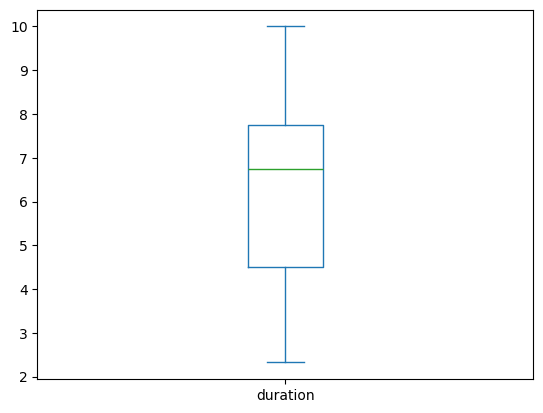

In [10]:
portfolio.duration.describe().plot.box()

<Axes: >

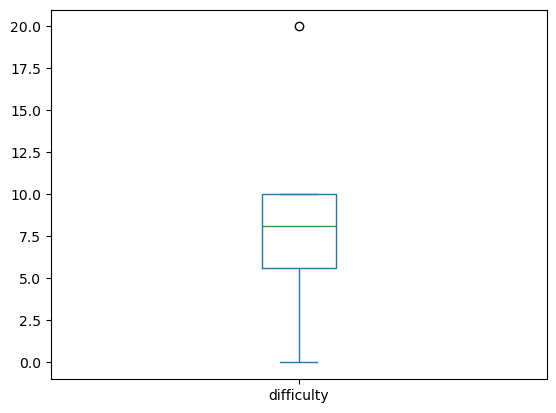

In [11]:
portfolio.difficulty.describe().plot.box()

<Axes: >

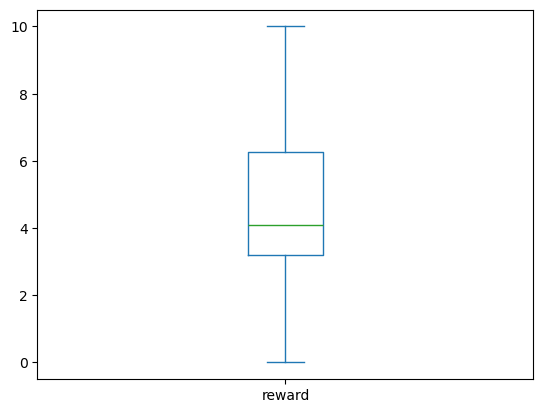

In [12]:
portfolio.reward.describe().plot.box()

<Axes: xlabel='offer_type'>

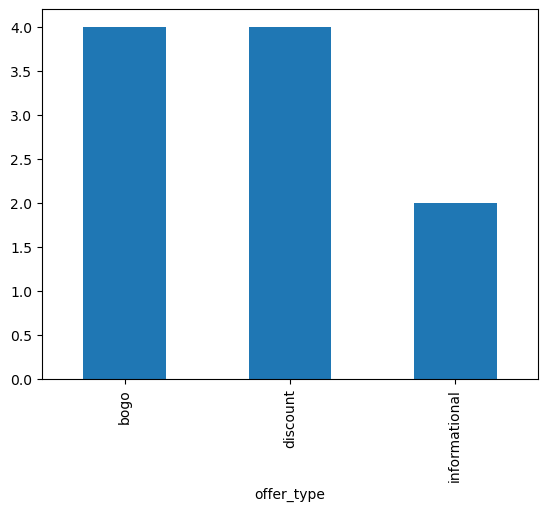

In [13]:

portfolio.offer_type.value_counts().T.plot.bar()

In [14]:
portfolio.offer_type.value_counts().to_frame().style.bar()

,count
offer_type,
bogo,4
discount,4
informational,2


In [15]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [16]:
# since all the channnels are formed in one column so we need to implement one hot encoding so model can learn what channels are associated with the portfolios 
portfolio.channels.value_counts()

channels
[web, email, mobile, social]    4
[web, email, mobile]            3
[email, mobile, social]         2
[web, email]                    1
Name: count, dtype: int64

In [17]:

mlb = MultiLabelBinarizer()
a = mlb.fit_transform(portfolio.channels.to_numpy())


portfolio_ohe = pd.DataFrame(a,portfolio.index, mlb.classes_)

processed_portfolio = pd.concat([portfolio,portfolio_ohe], axis=1)
processed_portfolio.head()

,reward,channels,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


In [18]:
processed_portfolio = processed_portfolio.drop(columns = 'channels')

processed_portfolio.head()

,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


In [19]:
processed_portfolio = processed_portfolio.rename(columns={'id':'offer_id'})
processed_portfolio.head()

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


#### All porfolio pre-processing is now done with the columns and its ready for some EDA analysis 

### Exploring Profile Data Frame and checking for null Values along with pre-processing

In [60]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [61]:
profile.shape

(17000, 5)

In [62]:
profile.dtypes

gender               object
age                   int64
id                   object
became_member_on      int64
income              float64
dtype: object

In [63]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [64]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [65]:
profile.columns

Index(['gender', 'age', 'id', 'became_member_on', 'income'], dtype='object')

In [66]:
profile.became_member_on = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [67]:
profile.dtypes

gender                      object
age                          int64
id                          object
became_member_on    datetime64[ns]
income                     float64
dtype: object

In [68]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [69]:
# extract the day, month, and year components
profile['day'] = profile['became_member_on'].dt.day
profile['month'] = profile['became_member_on'].dt.month
profile['year'] = profile['became_member_on'].dt.year

In [70]:
profile.head()

,gender,age,id,became_member_on,income,day,month,year
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,12,2,2017
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,15,7,2017
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,12,7,2018
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,9,5,2017
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,4,8,2017


In [71]:
profile.year.value_counts().to_frame().style.bar()

,count
year,
2017,6469
2018,4198
2016,3526
2015,1830
2014,691
2013,286


In [72]:
# filling the null income data points with mean age 
profile['income'] = profile['income'].fillna(profile['income'].mean())

In [73]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income                 0
day                    0
month                  0
year                   0
dtype: int64

In [74]:
#filling the gender missing using mode function , it will replace the null or missing values with most frequent gender values 
mode = profile['gender'].mode()[0]
profile['gender'] = profile['gender'].fillna(mode)

In [75]:
profile.isnull().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
day                 0
month               0
year                0
dtype: int64

In [76]:
profile.head()

,gender,age,id,became_member_on,income,day,month,year
0,M,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65404.991568,12,2,2017
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.000000,15,7,2017
2,M,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,65404.991568,12,7,2018
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.000000,9,5,2017
4,M,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,65404.991568,4,8,2017


In [77]:
profile.age.describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

In [78]:
# converting age into groups so it can be further one hot encoded and be helpful for modelling analysis 
bins = [18, 25, 30, 40,50,60,70,80,120]
group = ['18-25', '25-30', '30-40','40-50','50-60','60-70','70-80','80+']
profile['age_group'] = pd.cut(profile['age'], bins=bins, labels=group, right=False)


<Axes: xlabel='age_group'>

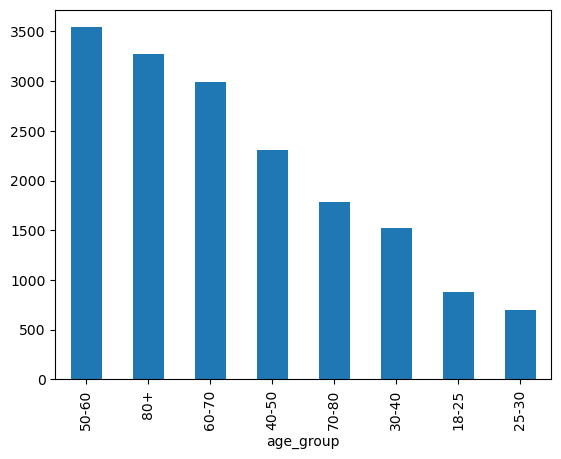

In [79]:
profile['age_group'].value_counts().plot.bar()

In [80]:
profile.head(n=20)

,gender,age,id,became_member_on,income,day,month,year,age_group
0,M,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65404.991568,12,2,2017,80+
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.000000,15,7,2017,50-60
2,M,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,65404.991568,12,7,2018,80+
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.000000,9,5,2017,70-80
4,M,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,65404.991568,4,8,2017,80+
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.000000,26,4,2018,60-70
6,M,118,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,65404.991568,25,9,2017,80+
7,M,118,68617ca6246f4fbc85e91a2a49552598,2017-10-02,65404.991568,2,10,2017,80+
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.000000,9,2,2018,60-70
9,M,118,8974fc5686fe429db53ddde067b88302,2016-11-22,65404.991568,22,11,2016,80+


In [81]:
profile['gender'].value_counts().to_frame().style.bar()

,count
gender,
M,10659
F,6129
O,212


In [42]:
profile.income.describe()

count     17000.000000
mean      65404.991568
std       20169.288288
min       30000.000000
25%       51000.000000
50%       65404.991568
75%       76000.000000
max      120000.000000
Name: income, dtype: float64

In [43]:
profile.columns

Index(['gender', 'age', 'id', 'became_member_on', 'income', 'day', 'month',
       'year', 'age_group'],
      dtype='object')

In [44]:
categorical_cols = ['gender', 'age_group'] 

#import pandas as pd
profile_onehot = pd.get_dummies(profile, columns = categorical_cols)

In [45]:
profile_onehot.columns

Index(['age', 'id', 'became_member_on', 'income', 'day', 'month', 'year',
       'gender_F', 'gender_M', 'gender_O', 'age_group_18-25',
       'age_group_25-30', 'age_group_30-40', 'age_group_40-50',
       'age_group_50-60', 'age_group_60-70', 'age_group_70-80',
       'age_group_80+'],
      dtype='object')

In [46]:
# profile_preprocessed = profile_onehot.drop(columns = 'age')

In [47]:
profile_preprocessed = profile_onehot
profile_preprocessed = profile_preprocessed.rename(columns = {'id':'customer_id'})

In [49]:
# not dropping gender column so it can be used in EDA 
profile_preprocessed['gender'] = profile['gender']
profile_preprocessed

,age,customer_id,became_member_on,income,day,month,year,gender_F,gender_M,gender_O,age_group_18-25,age_group_25-30,age_group_30-40,age_group_40-50,age_group_50-60,age_group_60-70,age_group_70-80,age_group_80+,gender
0,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65404.991568,12,2,2017,False,True,False,False,False,False,False,False,False,False,True,M
1,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.000000,15,7,2017,True,False,False,False,False,False,False,True,False,False,False,F
2,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,65404.991568,12,7,2018,False,True,False,False,False,False,False,False,False,False,True,M
3,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.000000,9,5,2017,True,False,False,False,False,False,False,False,False,True,False,F
4,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,65404.991568,4,8,2017,False,True,False,False,False,False,False,False,False,False,True,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.000000,4,6,2018,True,False,False,False,False,False,True,False,False,False,False,F
16996,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.000000,13,7,2018,False,True,False,False,False,False,False,False,True,False,False,M
16997,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.000000,26,1,2017,False,True,False,False,False,False,True,False,False,False,False,M
16998,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.000000,7,3,2016,True,False,False,False,False,False,False,False,False,False,True,F


In [92]:
profile_preprocessed['age_group'] = profile['age_group']

In [93]:
#note i have not dropped the became_member_on as i ll try to use it as time series feature as an optional step 
profile_preprocessed.head()

,age,customer_id,became_member_on,income,day,month,year,gender_F,gender_M,gender_O,age_group_18-25,age_group_25-30,age_group_30-40,age_group_40-50,age_group_50-60,age_group_60-70,age_group_70-80,age_group_80+,gender,age_group
0,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65404.991568,12,2,2017,False,True,False,False,False,False,False,False,False,False,True,M,80+
1,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.000000,15,7,2017,True,False,False,False,False,False,False,True,False,False,False,F,50-60
2,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,65404.991568,12,7,2018,False,True,False,False,False,False,False,False,False,False,True,M,80+
3,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.000000,9,5,2017,True,False,False,False,False,False,False,False,False,True,False,F,70-80
4,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,65404.991568,4,8,2017,False,True,False,False,False,False,False,False,False,False,True,M,80+


#### completing profile pre_processing and checking here 

### Exploring transcript Data Frame and checking for null Values along with pre-processing

In [51]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [52]:
transcript.shape

(306534, 4)

In [53]:
transcript.dtypes
#  person column needs renaming as customer id

person    object
event     object
value     object
time       int64
dtype: object

In [54]:
transcript.isnull().sum()
# no null values found 

person    0
event     0
value     0
time      0
dtype: int64

In [55]:

transcript = transcript.rename(columns = {'person':'customer_id'})
transcript.head()

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [56]:
transcript.event.value_counts().to_frame().style.bar()

,count
event,
transaction,138953
offer received,76277
offer viewed,57725
offer completed,33579


In [57]:
column = 'event'
transcript_dummy = pd.get_dummies(transcript[column])
transcript = pd.concat([transcript, transcript_dummy], axis=1 )

In [58]:
transcript.head()

,customer_id,event,value,time,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,False,True,False,False
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,False,True,False,False
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,False,True,False,False
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,False,True,False,False
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,False,True,False,False


In [188]:
transcript['offer_id'] = [[*i.values()][0] if [*i.keys()][0] in ['offer id', 'offer_id'] else 'Not Available' for i in transcript.value] 
transcript['amount'] = [[*i.values()][0] if [*i.keys()][0] in ['amount'] else 0 for i in transcript.value] 

In [189]:
transcript.head()

,customer_id,event,value,time,offer completed,offer received,offer viewed,transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,False,True,False,False,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,False,True,False,False,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,False,True,False,False,2906b810c7d4411798c6938adc9daaa5,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,False,True,False,False,fafdcd668e3743c1bb461111dcafc2a4,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,False,True,False,False,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0


In [190]:
# not dropping the event column here so it can be used for EDA 
#transcript_preprocessed = transcript.drop('event', axis =1)

In [191]:
transcript_preprocessed = transcript
transcript_preprocessed = transcript_preprocessed.drop('value', axis =1)

In [192]:
transcript_preprocessed.isnull().sum()

customer_id        0
event              0
time               0
offer completed    0
offer received     0
offer viewed       0
transaction        0
offer_id           0
amount             0
dtype: int64

#### completing transcript pre_processing and checking here 

### Now its time to merge all three data frames and begin Exploratory Data Analysis 

In [193]:
customer = pd.merge(profile_preprocessed,transcript_preprocessed,  on='customer_id', how='left')

In [194]:
customer.head()

,age,customer_id,became_member_on,income,day,month,year,gender_F,gender_M,gender_O,...,gender,age_group,event,time,offer completed,offer received,offer viewed,transaction,offer_id,amount
0,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65404.991568,12,2,2017,False,True,False,...,M,80+,offer received,168,False,True,False,False,2906b810c7d4411798c6938adc9daaa5,0.00
1,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65404.991568,12,2,2017,False,True,False,...,M,80+,offer viewed,216,False,False,True,False,2906b810c7d4411798c6938adc9daaa5,0.00
2,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65404.991568,12,2,2017,False,True,False,...,M,80+,offer received,336,False,True,False,False,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00
3,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65404.991568,12,2,2017,False,True,False,...,M,80+,offer viewed,348,False,False,True,False,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00
4,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65404.991568,12,2,2017,False,True,False,...,M,80+,transaction,360,False,False,False,True,Not Available,0.35


In [195]:
customer.isnull().sum()

age                 0
customer_id         0
became_member_on    0
income              0
day                 0
month               0
year                0
gender_F            0
gender_M            0
gender_O            0
age_group_18-25     0
age_group_25-30     0
age_group_30-40     0
age_group_40-50     0
age_group_50-60     0
age_group_60-70     0
age_group_70-80     0
age_group_80+       0
gender              0
age_group           0
event               0
time                0
offer completed     0
offer received      0
offer viewed        0
transaction         0
offer_id            0
amount              0
dtype: int64

In [196]:
customer = pd.merge(customer, processed_portfolio, on='offer_id', how='left')

In [197]:
customer.shape

(306534, 36)

In [198]:
customer.customer_id.nunique()

17000

In [199]:
#saving data so we can reload instead of doing all pre-processing again 
customer.to_csv('data/customer.csv', index=False)

In [82]:
customer = pd.read_csv('data/customer.csv')

In [5]:
customer.head()

,age,customer_id,became_member_on,income,day,month,year,gender_F,gender_M,gender_O,...,offer_id,amount,reward,difficulty,duration,offer_type,email,mobile,social,web
0,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65404.991568,12,2,2017,False,True,False,...,2906b810c7d4411798c6938adc9daaa5,0.00,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0
1,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65404.991568,12,2,2017,False,True,False,...,2906b810c7d4411798c6938adc9daaa5,0.00,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0
2,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65404.991568,12,2,2017,False,True,False,...,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0
3,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65404.991568,12,2,2017,False,True,False,...,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0
4,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65404.991568,12,2,2017,False,True,False,...,Not Available,0.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
customer.dtypes

age                          int64
customer_id                 object
became_member_on    datetime64[ns]
income                     float64
day                          int32
month                        int32
year                         int32
gender_F                      bool
gender_M                      bool
gender_O                      bool
age_group_18-25               bool
age_group_25-30               bool
age_group_30-40               bool
age_group_40-50               bool
age_group_50-60               bool
age_group_60-70               bool
age_group_70-80               bool
age_group_80+                 bool
gender                      object
event                       object
time                         int64
offer completed               bool
offer received                bool
offer viewed                  bool
transaction                   bool
offer_id                    object
amount                     float64
reward                     float64
difficulty          

In [71]:
customer.time.describe()

count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

In [72]:
customer.offer_type.value_counts()

offer_type
bogo             71617
discount         69898
informational    26066
Name: count, dtype: int64

In [73]:
customer.columns

Index(['age', 'customer_id', 'became_member_on', 'income', 'day', 'month',
       'year', 'gender_F', 'gender_M', 'gender_O', 'age_group_18-25',
       'age_group_25-30', 'age_group_30-40', 'age_group_40-50',
       'age_group_50-60', 'age_group_60-70', 'age_group_70-80',
       'age_group_80+', 'gender', 'event', 'time', 'offer completed',
       'offer received', 'offer viewed', 'transaction', 'offer_id', 'amount',
       'reward', 'difficulty', 'duration', 'offer_type', 'email', 'mobile',
       'social', 'web'],
      dtype='object')

In [74]:
columns_for_correlation = [ 'income', 'day', 'month', 'year',
       'gender_F', 'gender_M', 'gender_O', 'age_group_18-25',
       'age_group_25-30', 'age_group_30-40', 'age_group_40-50',
       'age_group_50-60', 'age_group_60-70', 'age_group_70-80',
       'age_group_80+', 'time', 'offer completed', 'offer received',
       'offer viewed', 'transaction', 'amount', 'reward',
       'difficulty', 'duration','email', 'mobile', 'social',
       'web']
data_corr = customer[columns_for_correlation]
correlations = data_corr.corr()


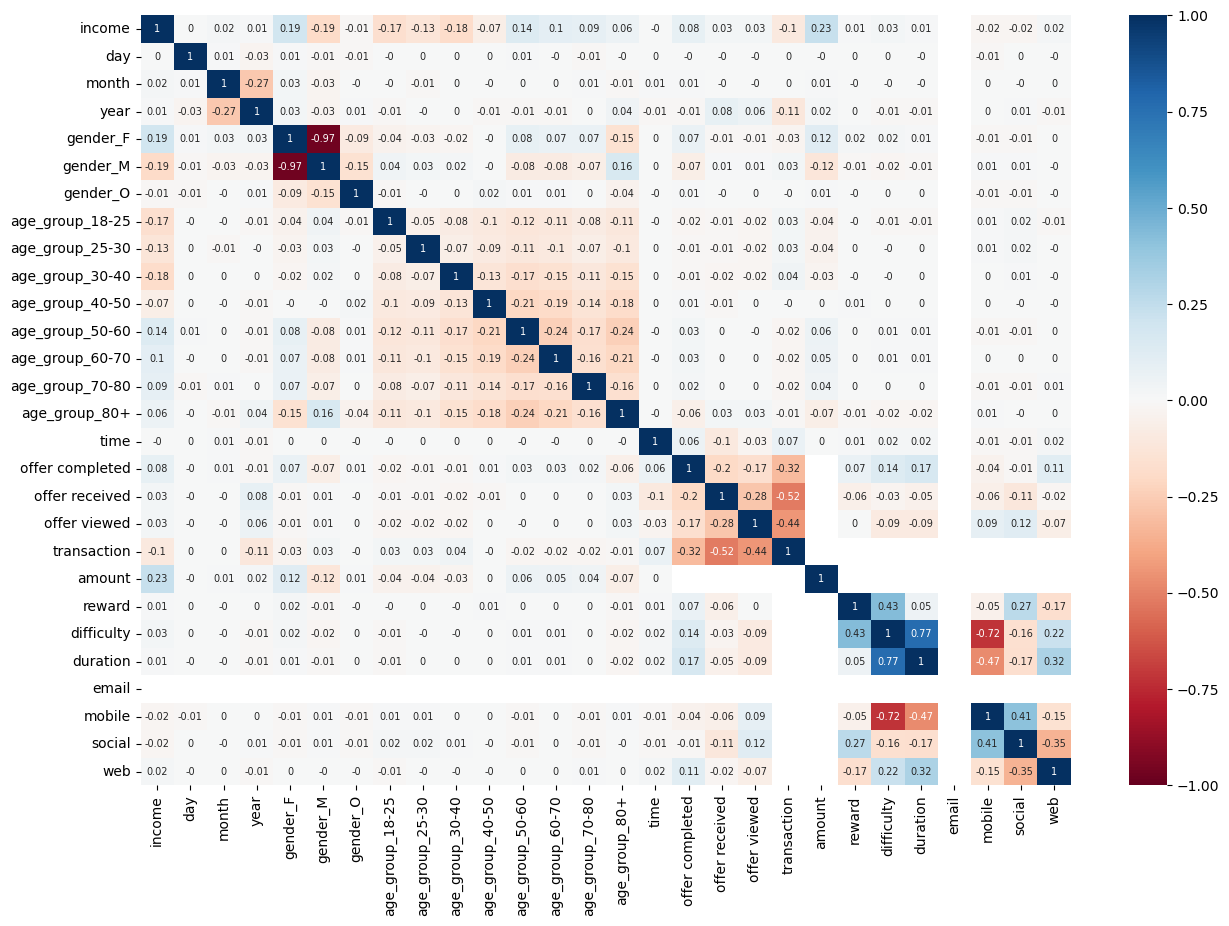

In [75]:
plt.figure(figsize=(15,10))
correlations = data_corr.corr()
sns.heatmap(round(correlations,2), cmap='RdBu', annot=True, 
            annot_kws={"size": 7}, vmin=-1, vmax=1);


##### checked here to see in case if any correlation exsists in features , it shows not much exsists which is good for our modelling 

In [76]:
customer.columns

Index(['age', 'customer_id', 'became_member_on', 'income', 'day', 'month',
       'year', 'gender_F', 'gender_M', 'gender_O', 'age_group_18-25',
       'age_group_25-30', 'age_group_30-40', 'age_group_40-50',
       'age_group_50-60', 'age_group_60-70', 'age_group_70-80',
       'age_group_80+', 'gender', 'event', 'time', 'offer completed',
       'offer received', 'offer viewed', 'transaction', 'offer_id', 'amount',
       'reward', 'difficulty', 'duration', 'offer_type', 'email', 'mobile',
       'social', 'web'],
      dtype='object')

              income
gender              
F       69546.750250
M       61447.532356
O       62897.758751


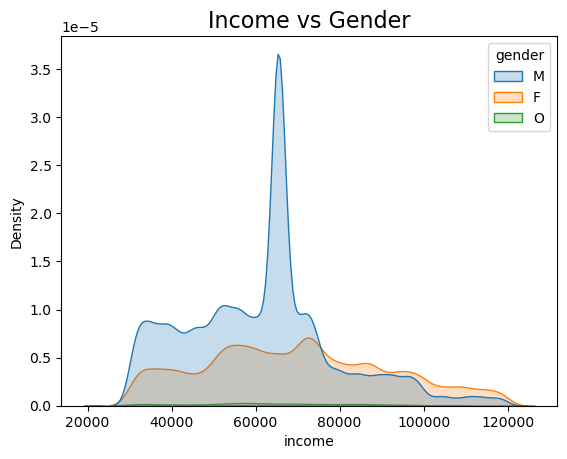

In [79]:
print(customer.groupby('gender').agg({'income': 'mean'}))
sns.kdeplot(data = customer, x = 'income', hue = 'gender', fill = True)
plt.title('Income vs Gender', fontsize = 16)
plt.show()

##### Male Income is mostly between 30K to 70K whereas female income density is bit higher which is from 32K to 85K, also in this overall portfolio of customer feamales are earning more compared to men as represented in terms of overall portfolio population  

                     age
offer_type              
bogo           61.638186
discount       61.712910
informational  62.880687


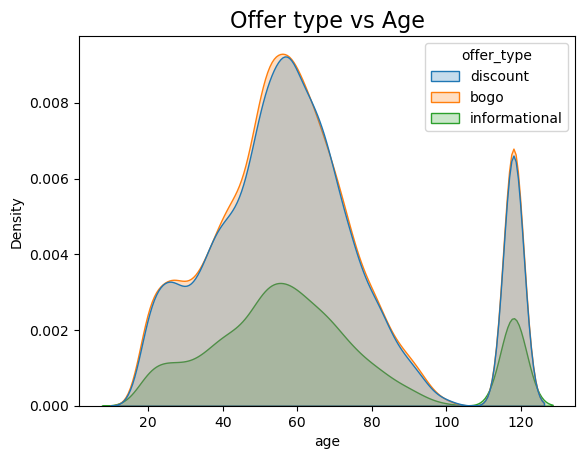

In [82]:
print(customer.groupby('offer_type').agg({'age': 'mean'}))
sns.kdeplot(data = customer, x = 'age', hue = 'offer_type', fill = True)
plt.title('Offer type vs Age', fontsize = 16)
plt.show()

In [85]:
customer.head()

,age,customer_id,became_member_on,income,day,month,year,gender_F,gender_M,gender_O,...,offer_id,amount,reward,difficulty,duration,offer_type,email,mobile,social,web
0,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65404.991568,12,2,2017,False,True,False,...,2906b810c7d4411798c6938adc9daaa5,NaN,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0
1,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65404.991568,12,2,2017,False,True,False,...,2906b810c7d4411798c6938adc9daaa5,NaN,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0
2,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65404.991568,12,2,2017,False,True,False,...,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0
3,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65404.991568,12,2,2017,False,True,False,...,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0
4,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65404.991568,12,2,2017,False,True,False,...,None,0.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


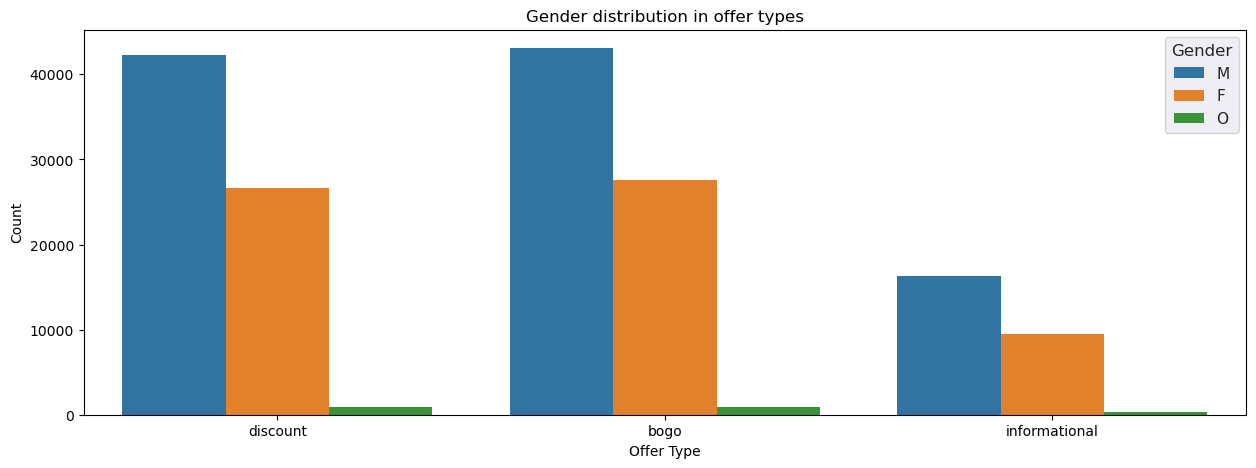

In [87]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "offer_type", hue= "gender", data=customer)
sns.set(style="darkgrid")
plt.title('Gender distribution in offer types')
plt.ylabel('Count')
plt.xlabel('Offer Type')
plt.legend(title='Gender')

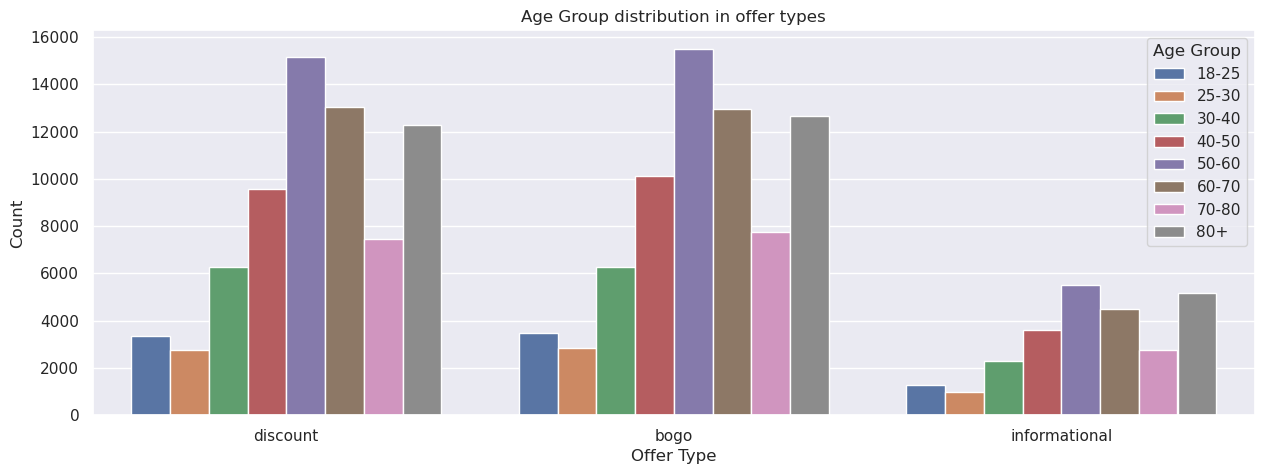

In [101]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "offer_type", hue= "age_group", data=customer)
sns.set(style="darkgrid")
plt.title('Age Group distribution in offer types')
plt.ylabel('Count')
plt.xlabel('Offer Type')
plt.legend(title='Age Group')

In [102]:
customer.columns

Index(['age', 'customer_id', 'became_member_on', 'income', 'day', 'month',
       'year', 'gender_F', 'gender_M', 'gender_O', 'age_group_18-25',
       'age_group_25-30', 'age_group_30-40', 'age_group_40-50',
       'age_group_50-60', 'age_group_60-70', 'age_group_70-80',
       'age_group_80+', 'gender', 'age_group', 'event', 'time',
       'offer completed', 'offer received', 'offer viewed', 'transaction',
       'offer_id', 'amount', 'reward', 'difficulty', 'duration', 'offer_type',
       'email', 'mobile', 'social', 'web'],
      dtype='object')

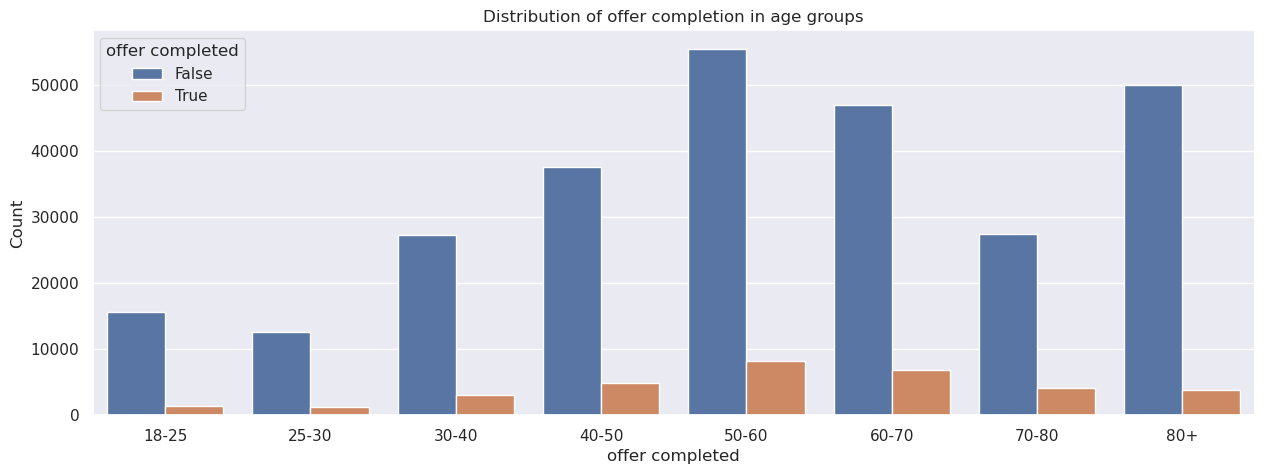

In [106]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "age_group", hue= "offer completed", data=customer)
plt.title('Distribution of offer completion in age groups')
plt.ylabel('Count')
plt.xlabel('offer completed')
plt.legend(title='offer completed')

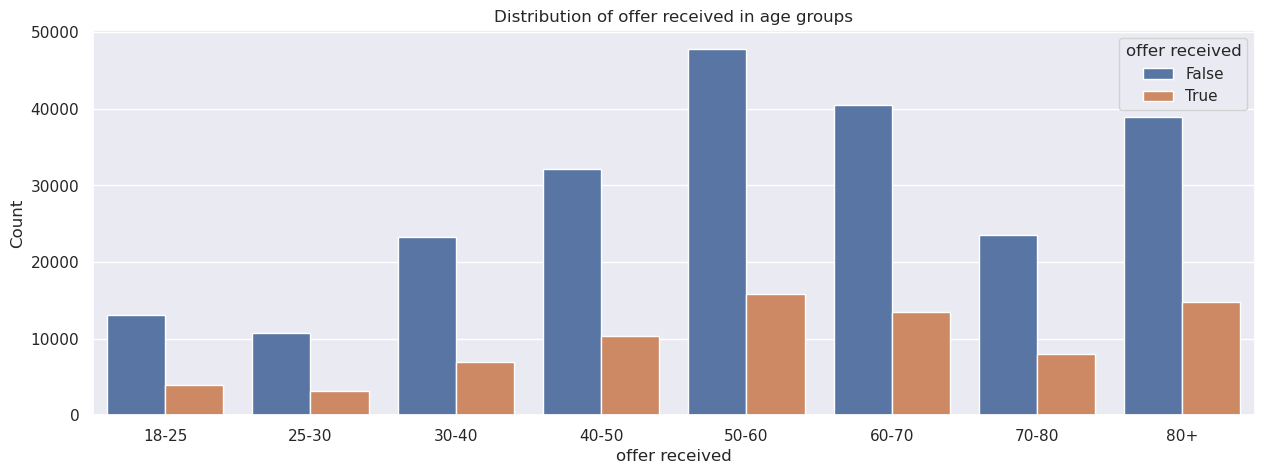

In [107]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "age_group", hue= "offer received", data=customer)
plt.title('Distribution of offer received in age groups')
plt.ylabel('Count')
plt.xlabel('offer received')
plt.legend(title='offer received')

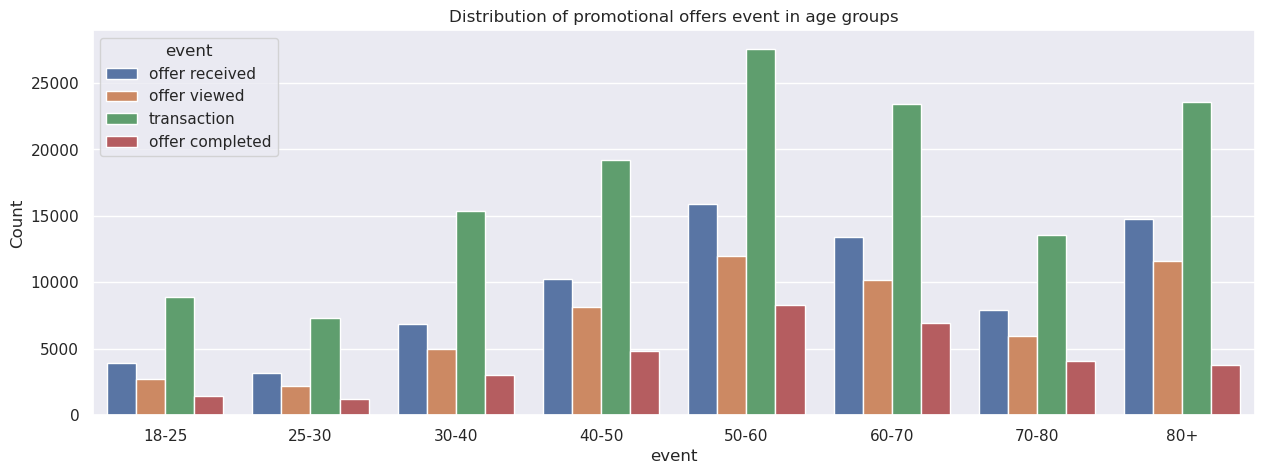

In [110]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "age_group", hue= "event", data=customer)
plt.title('Distribution of promotional offers event in age groups')
plt.ylabel('Count')
plt.xlabel('event')
plt.legend(title='event')

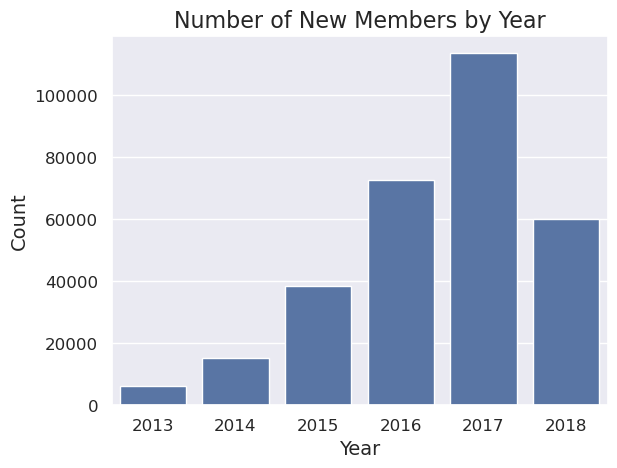

In [129]:
sns.countplot(data = customer, x = 'year')
plt.title('Number of Member Per Year', fontsize = 16)
plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
plt.xlabel('Year', fontsize = 14); plt.ylabel('Count', fontsize = 14)
plt.show()

In [208]:
customer['offer_id'].unique()

array(['2906b810c7d4411798c6938adc9daaa5',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7', 'Not Available',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '3f207df678b143eea3cee63160fa8bed',
       '5a8bc65990b245e5a138643cd4eb9837',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '4d5c57ea9a6940dd891ad53e9dbe8da0'], dtype=object)

In [210]:
# assigning heach offer ID a number so it can be checked which is completed or not  
unique_ids = list(customer['offer_id'].unique())

i=0   
for i in range(len(unique_ids)):
    
    customer['offer_id'] = customer['offer_id'].apply(lambda x: f'Offer ID {i+1}' if (x == unique_ids[i] and x != 'Not Available') else x)
        
            


In [211]:
customer['offer_id'].unique()

array(['Offer ID 1', 'Offer ID 2', 'Not Available', 'Offer ID 4',
       'Offer ID 5', 'Offer ID 6', 'Offer ID 7', 'Offer ID 8',
       'Offer ID 9', 'Offer ID 10', 'Offer ID 11'], dtype=object)

In [172]:
customer['offer_id'].value_counts()

offer_id
fafdcd668e3743c1bb461111dcafc2a4    20241
2298d6c36e964ae4a3e7e9706d1fb8c2    20139
f19421c1d4aa40978ebb69ca19b0e20d    19131
4d5c57ea9a6940dd891ad53e9dbe8da0    18222
ae264e3637204a6fb9bb56bc8210ddfd    18062
9b98b8c7a33c4b65b9aebfe6a799e6d9    16202
2906b810c7d4411798c6938adc9daaa5    15767
5a8bc65990b245e5a138643cd4eb9837    14305
0b1e1539f2cc45b7b9fa7c272da2e1d7    13751
3f207df678b143eea3cee63160fa8bed    11761
Name: count, dtype: int64

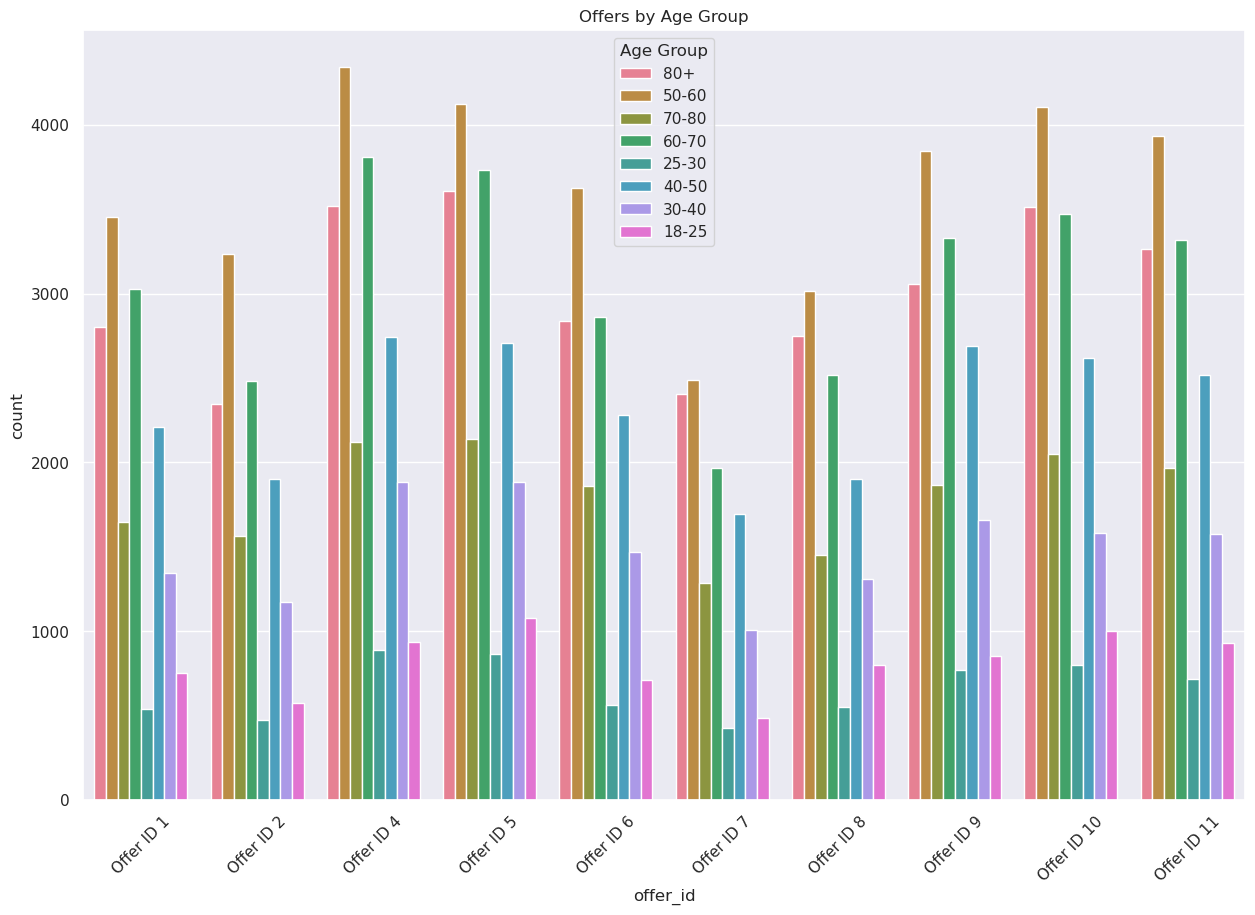

In [230]:
plt.figure(figsize=(15, 10))
sns.countplot(x='offer_id',hue='age_group',data=customer.loc[customer['offer_id'] != 'Not Available'],palette='husl');
plt.legend(title='Age Group')
plt.title('Offers by Age Group')

plt.xticks(rotation=45);

In [232]:
customer.columns

Index(['age', 'customer_id', 'became_member_on', 'income', 'day', 'month',
       'year', 'gender_F', 'gender_M', 'gender_O', 'age_group_18-25',
       'age_group_25-30', 'age_group_30-40', 'age_group_40-50',
       'age_group_50-60', 'age_group_60-70', 'age_group_70-80',
       'age_group_80+', 'gender', 'age_group', 'event', 'time',
       'offer completed', 'offer received', 'offer viewed', 'transaction',
       'offer_id', 'amount', 'reward', 'difficulty', 'duration', 'offer_type',
       'email', 'mobile', 'social', 'web'],
      dtype='object')

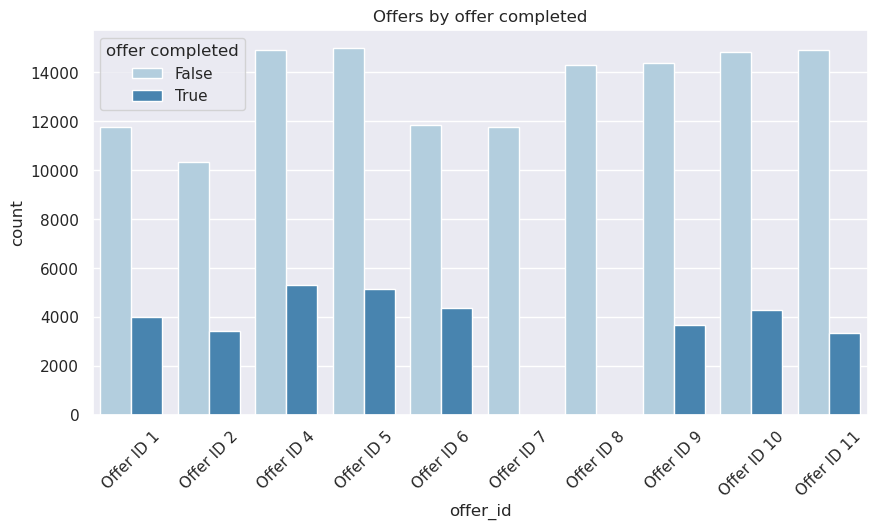

In [237]:
plt.figure(figsize=(10, 5))
sns.countplot(x='offer_id',hue='offer completed',data=customer.loc[customer['offer_id'] != 'Not Available'],palette='Blues');
plt.legend(title='offer completed')
plt.title('Offers by offer completed')

plt.xticks(rotation=45);

#### Checking for Feature Importance Now here

In [4]:
customer.columns

Index(['age', 'customer_id', 'became_member_on', 'income', 'day', 'month',
       'year', 'gender_F', 'gender_M', 'gender_O', 'age_group_18-25',
       'age_group_25-30', 'age_group_30-40', 'age_group_40-50',
       'age_group_50-60', 'age_group_60-70', 'age_group_70-80',
       'age_group_80+', 'gender', 'age_group', 'event', 'time',
       'offer completed', 'offer received', 'offer viewed', 'transaction',
       'offer_id', 'amount', 'reward', 'difficulty', 'duration', 'offer_type',
       'email', 'mobile', 'social', 'web'],
      dtype='object')

In [5]:
#First we will convert event into numerical values and then use train test split library for creating training data and testing data 
event_id = customer['event'].unique()
event_dictionary = pd.Series(event_id).to_dict()
event_dictionary = dict([(value, key) for key, value in event_dictionary.items()]) 
event_dictionary

{'offer received': 0,
 'offer viewed': 1,
 'transaction': 2,
 'offer completed': 3}

In [6]:
customer['id_event'] = customer['event'].map(event_dictionary)


In [7]:

customer['id_event'].value_counts()

id_event
2    138953
0     76277
1     57725
3     33579
Name: count, dtype: int64

In [8]:
offer_type_id = customer['offer_type'].unique()
offer_type_id_dictionary = pd.Series(offer_type_id).to_dict()
offer_type_id_dictionary = dict([(value, key) for key, value in offer_type_id_dictionary.items()]) 
customer['offer_type_id'] = customer['offer_type'].map(offer_type_id_dictionary)
customer['offer_type_id'].value_counts()

offer_type_id
1    138953
2     71617
0     69898
3     26066
Name: count, dtype: int64

In [9]:
customer.columns

Index(['age', 'customer_id', 'became_member_on', 'income', 'day', 'month',
       'year', 'gender_F', 'gender_M', 'gender_O', 'age_group_18-25',
       'age_group_25-30', 'age_group_30-40', 'age_group_40-50',
       'age_group_50-60', 'age_group_60-70', 'age_group_70-80',
       'age_group_80+', 'gender', 'age_group', 'event', 'time',
       'offer completed', 'offer received', 'offer viewed', 'transaction',
       'offer_id', 'amount', 'reward', 'difficulty', 'duration', 'offer_type',
       'email', 'mobile', 'social', 'web', 'id_event', 'offer_type_id'],
      dtype='object')

In [ ]:
modelling_features = [ 'income', 'month',
       'year', 'gender_F', 'gender_M', 'gender_O', 'age_group_18-25',
       'age_group_25-30', 'age_group_30-40', 'age_group_40-50',
       'age_group_50-60', 'age_group_60-70', 'age_group_70-80',
       'age_group_80+', 'time','offer_type_id','email', 'mobile', 'social',
        'web','amount', 'reward', 'difficulty', 'duration']
X = customer[modelling_features]

In [11]:
X.shape

(306534, 24)

In [12]:
Y = customer['id_event']

In [13]:
Y.shape

(306534,)

#### defining here 80% data for training and 20% for testing

In [83]:
from sklearn.model_selection import train_test_split
# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [84]:
X_train.shape, X_test.shape

((245227, 24), (61307, 24))

In [18]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(random_state=0)
# fit the model
classifier.fit(X_train, y_train)
# Predicting results here
y_pred = classifier.predict(X_test)
# Checking accuracy scores here
from sklearn.metrics import accuracy_score
print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with 10 decision-trees : 0.6872


In [19]:
feature_scores = pd.Series(classifier.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

time               0.277014
difficulty         0.111260
income             0.092076
web                0.080933
reward             0.073549
social             0.069704
duration           0.068374
amount             0.063938
mobile             0.058128
month              0.049829
year               0.021096
offer_type_id      0.013122
age_group_80+      0.002580
age_group_50-60    0.002532
age_group_60-70    0.002414
age_group_40-50    0.002300
age_group_70-80    0.002201
age_group_30-40    0.001954
gender_M           0.001843
gender_F           0.001705
age_group_18-25    0.001465
age_group_25-30    0.001378
gender_O           0.000606
email              0.000000
dtype: float64

<Axes: >

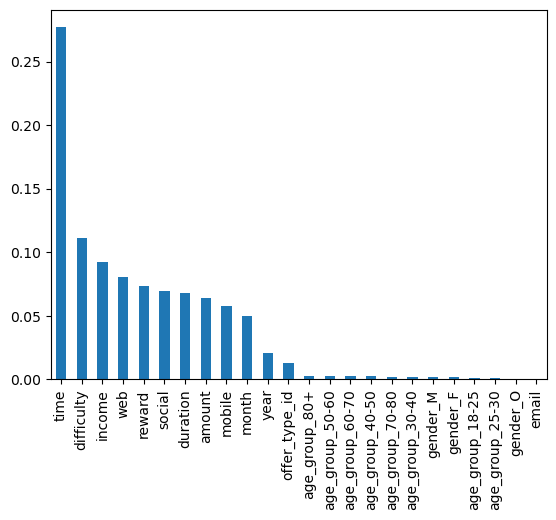

In [21]:
feature_scores.plot.bar()

In [26]:
# implementing standard scaler technique on income variable only 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train.income = scaler.fit_transform(X_train.income.values.reshape(-1, 1))

X_train.reset_index(inplace=True)
X_train = X_train.drop(['index'], axis=1)

X_test.income = scaler.transform(X_test.income.values.reshape(-1, 1))

X_test.reset_index(inplace=True)
X_test = X_test.drop(['index'], axis=1)

classifier = RandomForestClassifier(random_state=0)
# fit the model
classifier.fit(X_train, y_train)
# Predicting results here
y_pred = classifier.predict(X_test)
# Checking accuracy scores here
from sklearn.metrics import accuracy_score
print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with 10 decision-trees : 0.6870


#### this concludes that scalling doesnot increase the feature importance score 

### Now implementing Modelling techniques here below

In [33]:
X.fillna(X.mean(), inplace=True)

/tmp/ipykernel_1307/642802493.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)


In [86]:
from sklearn.model_selection import train_test_split

# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [ ]:
!pip install xgboost

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
Offers_event={'offer received': 0,
 'offer viewed': 1,
 'transaction': 2,
 'offer completed': 3}

In [29]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [30]:
y_pred = clf.predict(X_test)

In [31]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8070367168512568


In [37]:
print(classification_report(y_test, y_pred, target_names=Offers_event))

                 precision    recall  f1-score   support

 offer received       0.81      0.83      0.82     15337
   offer viewed       0.53      0.52      0.53     11571
    transaction       1.00      1.00      1.00     27658
offer completed       0.47      0.46      0.46      6741

       accuracy                           0.81     61307
      macro avg       0.70      0.70      0.70     61307
   weighted avg       0.81      0.81      0.81     61307



In [17]:
clf_rf = RandomForestClassifier(random_state=0)

In [18]:
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf, target_names=Offers_event))

                 precision    recall  f1-score   support

 offer received       0.58      0.64      0.61     15337
   offer viewed       0.29      0.28      0.28     11571
    transaction       1.00      1.00      1.00     27658
offer completed       0.26      0.21      0.23      6741

       accuracy                           0.69     61307
      macro avg       0.53      0.53      0.53     61307
   weighted avg       0.68      0.69      0.68     61307



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 2.5 MB/s eta 0:00:00:00:0100:01


In [87]:
from xgboost import XGBClassifier
clf_xgb = XGBClassifier(random_state=0)

In [88]:
clf_xgb.fit(X_train, y_train)
y_pred_xgb = clf_xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb, target_names=Offers_event))

                 precision    recall  f1-score   support

 offer received       0.83      1.00      0.91     15337
   offer viewed       0.74      0.59      0.66     11571
    transaction       1.00      1.00      1.00     27658
offer completed       0.63      0.56      0.59      6741

       accuracy                           0.87     61307
      macro avg       0.80      0.79      0.79     61307
   weighted avg       0.87      0.87      0.87     61307



In [24]:
parameters = {'n_estimators':[200, 500, 1000, 1500], 
              'learning_rate':[0.05, 0.1, 0.15, 0.2]}

In [37]:
ada = AdaBoostClassifier()

clf_ada = GridSearchCV(ada,parameters,cv=3,verbose=3,n_jobs=-1)

clf_ada.fit(X_train,y_train)
clf_ada.best_params_

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.1

[CV 1/3] END learning_rate=0.05, n_estimators=200;, score=0.777 total time=  46.2s
[CV 1/3] END learning_rate=0.05, n_estimators=500;, score=0.827 total time= 2.0min
[CV 3/3] END learning_rate=0.05, n_estimators=500;, score=0.827 total time= 1.7min
[CV 2/3] END learning_rate=0.05, n_estimators=1000;, score=0.826 total time= 3.3min
[CV 1/3] END learning_rate=0.05, n_estimators=1500;, score=0.850 total time= 5.4min
[CV 3/3] END learning_rate=0.05, n_estimators=1500;, score=0.849 total time= 5.2min
[CV 2/3] END learning_rate=0.1, n_estimators=500;, score=0.826 total time= 1.6min
[CV 1/3] END learning_rate=0.1, n_estimators=1000;, score=0.851 total time= 3.5min
[CV 3/3] END learning_rate=0.1, n_estimators=1000;, score=0.849 total time= 3.6min
[CV 2/3] END learning_rate=0.1, n_estimators=1500;, score=0.849 total time= 5.3min
[CV 1/3] END learning_rate=0.15, n_estimators=200;, score=0.827 total time=  56.1s
[CV 2/3] END learning_rate=0.15, n_estimators=200;, score=0.826 total time=  41.8s
[C

{'learning_rate': 0.2, 'n_estimators': 1500}

In [ ]:
ada = AdaBoostClassifier(learning_rate= 0.2, n_estimators= 1500)
ada.fit(X_train,y_train)


In [42]:
y_pred_ada = ada.predict(X_test)

In [43]:
print(classification_report(y_test, y_pred_ada, target_names=Offers_event))

                 precision    recall  f1-score   support

 offer received       0.83      1.00      0.91     15337
   offer viewed       0.63      0.69      0.66     11571
    transaction       1.00      1.00      1.00     27658
offer completed       0.57      0.21      0.31      6741

       accuracy                           0.86     61307
      macro avg       0.76      0.73      0.72     61307
   weighted avg       0.84      0.86      0.84     61307



In [45]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:

gbc_clf = GradientBoostingClassifier()
clf_gbc_cv = GridSearchCV(gbc_clf,parameters,cv=2)
clf_gbc_cv.fit(X_train,y_train)
clf_gbc_cv.best_params_

In [ ]:
clf_gbc_cv.best_params_

In [48]:

gbc_clf_bst = GradientBoostingClassifier(learning_rate= 0.2, n_estimators= 1500)
gbc_clf_bst.fit(X_train,y_train)

GradientBoostingClassifier(learning_rate=0.2, n_estimators=1500)

In [49]:
y_pred_gbc = gbc_clf_bst.predict(X_test)

In [50]:
print(classification_report(y_test, y_pred_gbc, target_names=Offers_event))

                 precision    recall  f1-score   support

 offer received       0.83      1.00      0.91     15337
   offer viewed       0.74      0.58      0.65     11571
    transaction       1.00      1.00      1.00     27658
offer completed       0.61      0.56      0.58      6741

       accuracy                           0.87     61307
      macro avg       0.80      0.78      0.79     61307
   weighted avg       0.87      0.87      0.87     61307



In [52]:
import pickle

In [54]:
filename = 'finalized_model.pkl'
pickle.dump(gbc_clf_bst, open(filename, 'wb'))

In [57]:
import boto3
import pickle
s3_resource = boto3.resource('s3')
bucket='sagemaker-us-east-1-892930225158'
key='finalized_model.pkl'
pickle_byte_obj = pickle.dumps(gbc_clf_bst)

s3_resource.Object(bucket,key).put(Body=pickle_byte_obj)

{'ResponseMetadata': {'RequestId': 'TY226FWTRNW1CA95',
  'HostId': 'D7u5RUYCkZMjKoaoNUw2GWWv/MeQeceZyhrqDPS2ksvAA8wIzEsOX0xc5x8JdVYzfIEMr/ehbnY=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'D7u5RUYCkZMjKoaoNUw2GWWv/MeQeceZyhrqDPS2ksvAA8wIzEsOX0xc5x8JdVYzfIEMr/ehbnY=',
   'x-amz-request-id': 'TY226FWTRNW1CA95',
   'date': 'Tue, 18 Jun 2024 14:00:05 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"833e807c9dcbe2ea0fbda2ed48f59986"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"833e807c9dcbe2ea0fbda2ed48f59986"',
 'ServerSideEncryption': 'AES256'}